In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
from tqdm import trange
from torch.nn.functional import pad
from torch.nn.utils import clip_grad_value_
import matplotlib.pyplot as plt
from transformer_model import Transformer, SelfAttention, MLP

In [2]:
device = "cuda"

In [4]:
dims = 10
seq_len = 10

In [5]:
def generate_data(batch_size, seq_len, dims):
    w = torch.normal(0, 1, size=(batch_size, dims), device=device)
    x = torch.normal(0, 1, size=(batch_size, seq_len, dims), device=device)
    y = torch.einsum("bp, blp -> bl", w, x)
    y = pad(input=y.unsqueeze(-1), pad=(0, dims-1), mode="constant", value=0.0)
    assert y.shape == (batch_size, seq_len, dims)
    interweaved = torch.stack((x, y), dim=2).view(batch_size, 2 * seq_len, dims)
    return x, y, w, interweaved

In [9]:
def train(model, steps=2000):
    loss_list = []
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    for _ in trange(steps):
        x, y, w, interweaved = generate_data(batch_size=64, seq_len=seq_len, dims=dims)
        output = model(interweaved[:, :-1, :])
        pred = output[:, ::2, 0]
        loss = torch.mean((pred - y[:, :, 0]) ** 2)
        assert not torch.isnan(loss), loss
        optimizer.zero_grad()
        loss.backward()
        clip_grad_value_(model.parameters(), 0.01)
        optimizer.step()
        loss_list.append(loss.item())
    return model, loss_list

In [11]:
transformer = Transformer(
    num_layers=12,
    input_dim=dims,
    num_heads=4,
    mlp_hidden_dim=16,
    is_causal=True,
    activation="relu"
).to(device)

transformer, loss_list = train(transformer)
plt.plot(np.arange(len(loss_list)), np.log(loss_list))
plt.show()

transformer.eval()
with torch.no_grad():
    x, y, w, interweaved = generate_data(batch_size=1, seq_len=seq_len, dims=dims)
    output = transformer(interweaved[:, :-1, :])
    pred = output[:, ::2, 0]
    loss = torch.mean((pred - y[:, :, 0]) ** 2)
    print(pred)
    print(y[:, :, 0])
    print(loss)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


AssertionError: tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:22<00:00, 87.56it/s]


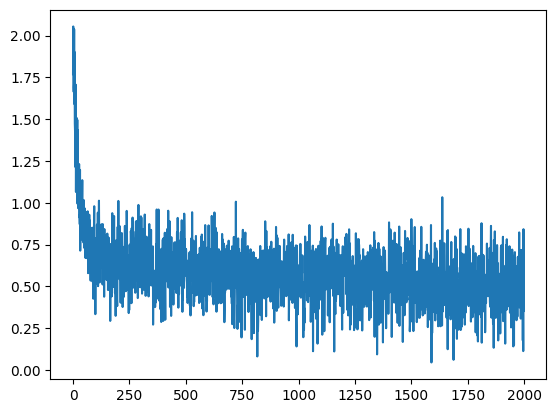

tensor([[ 0.1117,  0.0320, -0.0322,  0.0651,  0.1853, -0.0752, -0.1189, -0.0404,
         -0.1272, -0.0202]], device='cuda:0')
tensor([[ 1.4235,  1.0187, -0.0899,  1.7797,  0.7649,  0.6478,  0.1365, -1.1438,
          0.7574, -0.6985]], device='cuda:0')
tensor(0.9021, device='cuda:0')


In [116]:
transformer = Transformer(
    num_layers=4,
    input_dim=dims,
    num_heads=4,
    mlp_hidden_dim=16,
    is_causal=True,
    activation="softmax"
).to(device)

transformer, loss_list = train(transformer)
plt.plot(np.arange(len(loss_list)), np.log(loss_list))
plt.show()

transformer.eval()
with torch.no_grad():
    x, y, w, interweaved = generate_data(batch_size=1, seq_len=seq_len, dims=dims)
    output = transformer(interweaved[:, :-1, :])
    pred = output[:, ::2, 0]
    loss = torch.mean((pred - y[:, :, 0]) ** 2)
    print(pred)
    print(y[:, :, 0])
    print(loss)

100%|██████████| 2000/2000 [00:11<00:00, 177.35it/s]


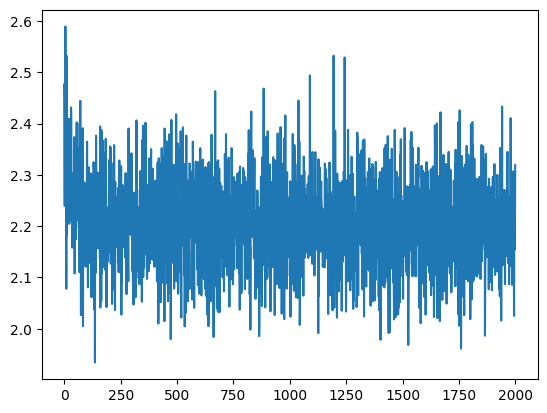

tensor([[-1.1055, -1.2949, -1.4976, -1.2007, -0.9178, -0.9876, -1.4306, -0.7738,
         -0.8918, -1.3404]], device='cuda:0')
tensor([[-0.8963, -4.0648, -1.7615,  0.9743, -3.8029,  1.3718, -6.0975,  2.5556,
          2.7628, -3.6163]], device='cuda:0')
tensor(7.7807, device='cuda:0')


In [12]:
transformer = Transformer(
    num_layers=4,
    input_dim=dims,
    num_heads=4,
    mlp_hidden_dim=16,
    is_causal=False,
    activation="softmax"
).to(device)

transformer, loss_list = train(transformer)
plt.plot(np.arange(len(loss_list)), np.log(loss_list))
plt.show()

transformer.eval()
with torch.no_grad():
    x, y, w, interweaved = generate_data(batch_size=1, seq_len=seq_len, dims=dims)
    output = transformer(interweaved[:, :-1, :])
    pred = output[:, ::2, 0]
    loss = torch.mean((pred - y[:, :, 0]) ** 2)
    print(pred)
    print(y[:, :, 0])
    print(loss)

100%|██████████| 10000/10000 [06:32<00:00, 25.47it/s]


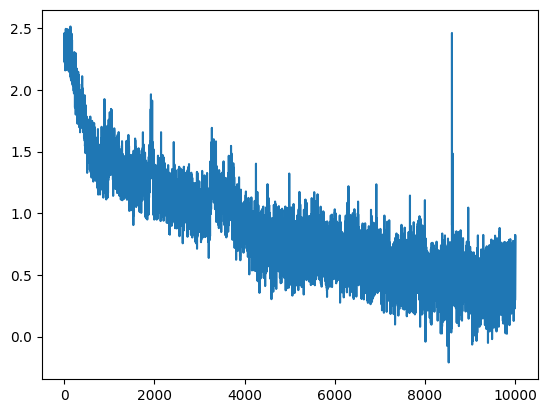

tensor([[-2.4905,  1.0165,  4.0728, -1.0224,  0.1428, -0.4049, -1.2118, -5.6113,
          0.3304,  0.0849]], device='cuda:0')
tensor([[-2.1443,  0.2320,  5.4116, -0.6048, -0.0749, -0.5420, -0.1189, -5.0377,
          1.3821, -3.2981]], device='cuda:0')
tensor(1.6842, device='cuda:0')


In [14]:
transformer = Transformer(
    num_layers=12,
    input_dim=dims,
    num_heads=4,
    mlp_hidden_dim=128,
    is_causal=True,
    activation="softmax",
    layer_norm=True,
    seq_len=2*seq_len-1,
    embed_dim=128
).to(device)

transformer, loss_list = train(transformer, steps=10000)
plt.plot(np.arange(len(loss_list)), np.log(loss_list))
plt.show()

transformer.eval()
with torch.no_grad():
    x, y, w, interweaved = generate_data(batch_size=1, seq_len=seq_len, dims=dims)
    output = transformer(interweaved[:, :-1, :])
    pred = output[:, ::2, 0]
    loss = torch.mean((pred - y[:, :, 0]) ** 2)
    print(pred)
    print(y[:, :, 0])
    print(loss)

## Debug Causal Masking

In [41]:
# debug
transformer = Transformer(
    num_layers=4,
    input_dim=dims,
    num_heads=4,
    mlp_hidden_dim=16,
    is_causal=True,
    activation="softmax"
).to(device)

loss_list = []
optimizer = torch.optim.SGD(transformer.parameters(), lr=0.01)
for _ in trange(2000):
    x, y, w, interweaved = generate_data(batch_size=64, seq_len=seq_len, dims=dims)
    output = transformer(interweaved[:, :-1, :])
    pred = output[:, ::2, 0]
    loss = torch.mean((pred - y[:, :, 0]) ** 2)
    assert not torch.isnan(loss), loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

100%|██████████| 2000/2000 [00:31<00:00, 63.94it/s]


In [47]:
x, y, w, interweaved = generate_data(batch_size=1, seq_len=seq_len, dims=dims)
interweaved.requires_grad = True
output = transformer(interweaved[:, :-1, :])
optimizer.zero_grad()
output[0, 6, 0].backward()

In [48]:
interweaved.grad

tensor([[[ 0.0458,  0.0417,  0.0143, -0.0805, -0.0126],
         [-0.0267, -0.0321, -0.0375, -0.0080, -0.0703],
         [-0.0060, -0.0053, -0.0117,  0.0362,  0.0117],
         [-0.0244,  0.0378,  0.0060,  0.0579,  0.0712],
         [ 0.0247,  0.0800,  0.0448,  0.0526,  0.0424],
         [-0.0356,  0.0505, -0.0144,  0.0767,  0.0475],
         [ 0.0698, -0.1838,  0.0017, -0.0841, -0.1060],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0